In [43]:
import pandas as pd
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
from explainerdashboard import ClassifierExplainer
# To run in python
from explainerdashboard import InlineExplainer
# Uses Port Forwarding as default.
from explainerdashboard import ExplainerDashboard
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

#Assessing Gflops and Runtime
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [44]:
data = pd.read_csv('../Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

In [45]:
# Sample for faster run time.
data = data.sample(n=10000, random_state=123)

In [46]:
data.columns = data.columns.str.replace(' ', '')
data.columns = data.columns.str.replace('.', '')
data.columns = data.columns.str.replace('_', '')

In [47]:
# Remove inf if exists (random sampling).
#data = data[~np.isinf(data).any(axis=1)]

#Going to try this code so that I can remove inf (This works better than the previous row and you dont get an error
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

!!ERROR ENCOUNTERED: It seems the Standard Scaler turns some of the feature values to infiniti. From there they need to be filtered and then the data put back to the scaler. So far it seems to be just a single row
each time but it occurs every time regardless of the random sample. (CIC2017 dataset)

Accuracy: 0.9985


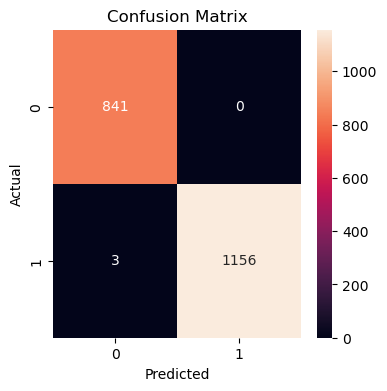

Time taken: 0.010652 seconds
Estimated GFLOPS: 0.187753


In [42]:
# Encode Label
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])
X = data.drop(columns=['Label'])
y = data['Label']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# Apply SMOTE to the training data
#smote = SMOTE(random_state=123)
#X_train, y_train = smote.fit_resample(X_train, y_train)

rf = RandomForestClassifier(random_state=123)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
# 98%!
print(f'Accuracy: {accuracy}')
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Time the prediction
start = time.time()
y_pred = rf.predict(X_test)
end = time.time()

# Approx FLOPs
n_samples = X_test.shape[0]
n_trees = len(rf.estimators_)
avg_depth = 10  # based on max_depth or estimate

flops = n_samples * n_trees * avg_depth
gflops = flops / ((end - start) * 1e9)

print(f"Time taken: {end - start:.6f} seconds")
print(f"Estimated GFLOPS: {gflops:.6f}")

In [13]:
# Print classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00       841
        DDoS       1.00      1.00      1.00      1159

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



Accuracy: 0.998


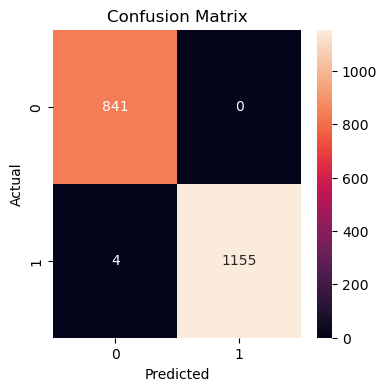

Time taken: 0.017484 seconds
Estimated GFLOPS: 0.114391


In [48]:
# Encode label
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])

# Assume these are your categorical columns (update this list based on your actual dataset)
categorical_columns = ['DestinationPort']  # Example: replace with your actual categorical column names

# Convert categorical columns to numeric (but not one-hot encode!)
cat_col_indices = [data.columns.get_loc(col) for col in categorical_columns]
for col in categorical_columns:
    data[col] = LabelEncoder().fit_transform(data[col])

# Separate features and target
X = data.drop(columns=['Label'])
y = data['Label']

# Split before scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Apply SMOTENC before scaling
smote_nc = SMOTENC(categorical_features=cat_col_indices, random_state=123)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

# Scale continuous features after resampling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Train model
rf = RandomForestClassifier(class_weight='balanced', random_state=123)
rf.fit(X_train_scaled, y_train_resampled)
y_pred = rf.predict(X_test_scaled)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Time the prediction
start = time.time()
y_pred = rf.predict(X_test)
end = time.time()

# Approx FLOPs
n_samples = X_test.shape[0]
n_trees = len(rf.estimators_)
avg_depth = 10  # based on max_depth or estimate

flops = n_samples * n_trees * avg_depth
gflops = flops / ((end - start) * 1e9)

print(f"Time taken: {end - start:.6f} seconds")
print(f"Estimated GFLOPS: {gflops:.6f}")

In [24]:
# Print classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00       841
        DDoS       1.00      1.00      1.00      1159

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

